##PHISHING-URL-DETECTION PROJECT
*Ibn Zohr University*

*IT Excellence Center*

*Cyber Security Module*

*ELQORACHI Hind - JAAFAR Wafa - MISBAH Asma - BELFAIK Chayma*

*Academic Year 2025-2026*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

features_df = pd.read_csv('/content/drive/MyDrive/url-phishing-detection/CyberSecurity/Data/features_dataset.csv')

df.sample(n=10)


,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,HTTPS,Shortener,Prefix_Suffix,Subdomain_Count,...,RightClick,Forwarding,Form_Tag,Suspicious_JS,Trusted_Domain,Manual_Shortener,Fake_Secure_Keyword,Suspicious_TLD,Suspicious_Path,Label
19204,NaN,0,0,0,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
10902,xoxodiana.com,0,0,0,3,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
19357,NaN,0,0,0,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
20864,NaN,0,0,0,5,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
32259,facebook.com,0,0,0,1,0,1,0,0,1,...,1,0,0,0,1,0,0,0,0,1
14019,NaN,0,0,1,5,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
37923,NaN,0,0,1,4,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
33383,NaN,0,0,0,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
19166,NaN,0,0,0,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
9696,iptvschedule.com,0,0,0,2,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
def featureExtraction(url):
    features = []

    # Remove leading/trailing whitespace
    url = url.strip()

    # Ensure URL has a scheme for correct parsing
    if not url.startswith(('http://', 'https://')):
        url = 'http://' + url  # assume http if missing

    # Regex pattern for URL shortening services
    shortening_services = r"(bit\.ly|goo\.gl|tinyurl|t\.co|ow\.ly|is\.gd|buff\.ly|adf\.ly|bitly)"

    # Manual override lists
    trusted_domains = [
        "google.com", "amazon.com", "microsoftonline.com",
        "gmail.com", "outlook.com", "apple.com", "github.com",
        "facebook.com", "youtube.com"
    ]

    shorteners_list = ["bit.ly", "tinyurl", "t.co", "goo.gl", "is.gd", "ow.ly"]

    fake_secure_keywords = [
        "secure-", "security-", "verify", "verification", "validate",
        "confirm", "confirmation", "update-info", "update-account",
        "unlock", "recovery", "support-center", "customer-support",
        "login-secure", "account-protect", "identity-check"
    ]

    suspicious_tlds = [
        ".xyz", ".top", ".click", ".info", ".monster", ".online",
        ".live", ".space", ".site", ".loan", ".stream"
    ]

    suspicious_path_keywords = [
        "login", "verify", "update", "signin", "account", "secure",
        "wp-admin", "password", "billing"
    ]

    # -------------------------
    # Domain & URL
    # -------------------------
    parsed = urlparse(url)
    domain = parsed.netloc.replace("www.", "").rstrip('/')
    path = parsed.path

    features.append(domain)   # keep domain string as first element

    # -------------------------
    # 1–20. Lexical & HTML features
    # -------------------------
    try:
        ipaddress.ip_address(domain)
        features.append(1)
    except:
        features.append(0)

    features.append(1 if "@" in url else 0)
    features.append(1 if len(url) >= 54 else 0)
    features.append(len([x for x in path.split("/") if x]))
    features.append(1 if url.rfind("//") > 6 else 0)
    features.append(1 if url.startswith("https") else 0)
    features.append(1 if re.search(shortening_services, url) else 0)
    features.append(1 if "-" in domain else 0)
    features.append(len(domain.split(".")) - 1)
    features.append(sum(c.isdigit() for c in domain))
    features.append(len(re.findall(r"[^a-zA-Z0-9.]", domain)))

    keywords = ["secure", "account", "update", "login", "verify", "bank", "confirm"]
    features.append(1 if any(k in url.lower() for k in keywords) else 0)

    features.append(1 if len(domain) < 10 else 0)
    features.append(1 if domain.endswith((".com", ".org", ".net")) else 0)

    # HTML features
    try:
        r = requests.get(url, timeout=3)
        html = r.text
    except:
        html = ""

    features.append(0 if "<iframe" in html else 1)
    features.append(1 if "onmouseover" in html else 0)
    features.append(0 if "event.button" in html else 1)
    features.append(1 if "window.location" in html else 0)
    features.append(1 if "<form" in html else 0)

    suspicious_js = ["eval(", "escape(", "unescape("]
    features.append(1 if any(f in html for f in suspicious_js) else 0)

    # -------------------------
    # 🔥 Manual override features integrated
    # -------------------------
    domain_lower = domain.lower()

    features.append(1 if any(td in domain_lower for td in trusted_domains) else 0)
    features.append(1 if any(sh in domain_lower for sh in shorteners_list) else 0)
    features.append(1 if any(k in url.lower() for k in fake_secure_keywords) else 0)
    features.append(1 if any(domain_lower.endswith(tld) for tld in suspicious_tlds) else 0)
    features.append(1 if any(k in path.lower() for k in suspicious_path_keywords) else 0)

    return features


In [ ]:
import pandas as pd

# Drop domain (string) before training
X = features_df.drop(['Domain', 'Label'], axis=1)
y = features_df['Label']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"   # FAST
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel='rbf', C=1, gamma='scale', probability=True))
])

svm.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=1, probability=True))])

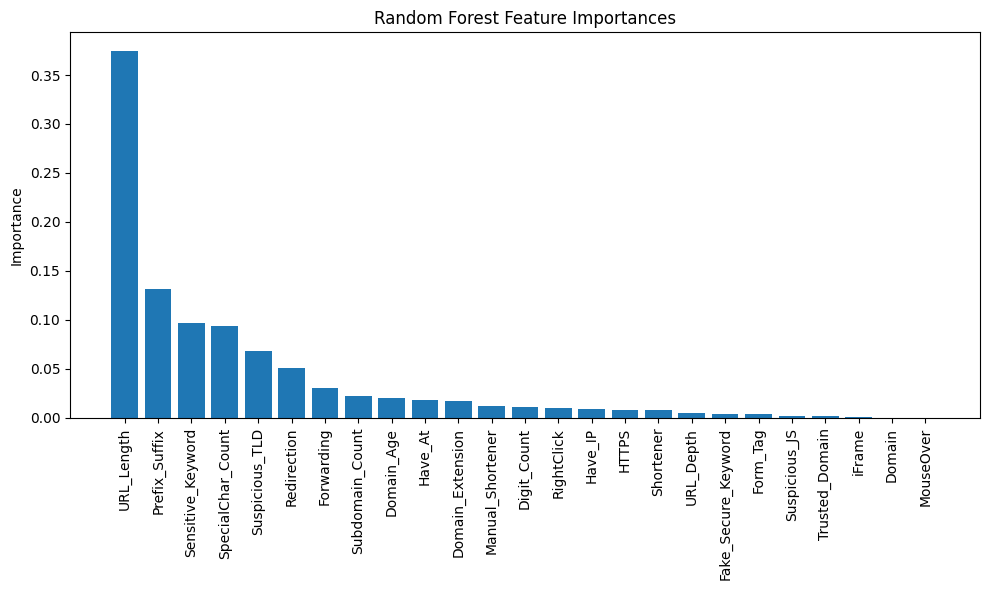

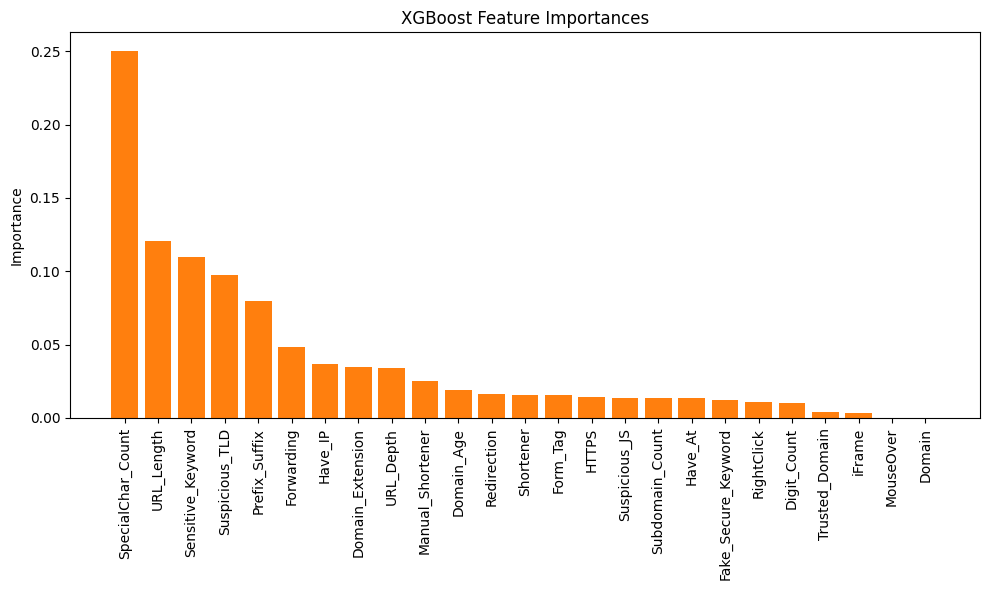

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = [
    'Domain',                 # extracted domain string
    'Have_IP',                # 1 if domain is an IP
    'Have_At',                # 1 if '@' in URL
    'URL_Length',             # 1 if len(URL) >= 54
    'URL_Depth',              # number of path segments
    'Redirection',            # 1 if '//' occurs after protocol
    'HTTPS',                  # 1 if HTTPS present
    'Shortener',              # 1 if URL shortening service regex
    'Prefix_Suffix',          # 1 if '-' in domain
    'Subdomain_Count',        # number of subdomains
    'Digit_Count',            # digits in domain
    'SpecialChar_Count',      # non-alphanumeric characters in domain
    'Sensitive_Keyword',      # 1 if URL contains sensitive keywords
    'Domain_Age',             # heuristic for short domain
    'Domain_Extension',       # heuristic for .com/.org/.net
    'iFrame',                 # 1 if no iframe tag
    'MouseOver',              # 1 if onmouseover present
    'RightClick',             # 1 if right-click disabled
    'Forwarding',             # 1 if window.location forwarding
    'Form_Tag',               # 1 if <form> tag present
    'Suspicious_JS',          # 1 if eval/escape/unescape
    'Trusted_Domain',         # 1 if domain is known trusted site
    'Manual_Shortener',       # 1 if domain matches known shortener
    'Fake_Secure_Keyword',    # 1 if URL contains fake security words
    'Suspicious_TLD',         # 1 if domain ends with suspicious TLD
    'Suspicious_Path'         # 1 if path contains suspicious keywords
]

# -------------------------
# Random Forest Feature Importance
# -------------------------
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]  # descending order

plt.figure(figsize=(10,6))
plt.bar(range(len(importances_rf)), importances_rf[indices_rf], color='#1f77b4')
plt.xticks(range(len(importances_rf)), np.array(feature_names)[indices_rf], rotation=90)
plt.title('Random Forest Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
plt.close()

# -------------------------
# XGBoost Feature Importance
# -------------------------
importances_xgb = xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances_xgb)), importances_xgb[indices_xgb], color='#ff7f0e')
plt.xticks(range(len(importances_xgb)), np.array(feature_names)[indices_xgb], rotation=90)
plt.title('XGBoost Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "SVM": svm
}

for name, model in models.items():
    preds = model.predict(X_test)
    print("\n-----------------------------")
    print(f" {name} RESULTS")
    print("-----------------------------")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))



-----------------------------
 Random Forest RESULTS
-----------------------------
Accuracy: 0.8255
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      4000
           1       0.80      0.87      0.83      4000

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000


-----------------------------
 XGBoost RESULTS
-----------------------------
Accuracy: 0.824625
              precision    recall  f1-score   support

           0       0.85      0.78      0.82      4000
           1       0.80      0.87      0.83      4000

    accuracy                           0.82      8000
   macro avg       0.83      0.82      0.82      8000
weighted avg       0.83      0.82      0.82      8000


-----------------------------
 SVM RESULTS
-----------------------------
Accuracy: 0.818625
              precision    recall  f1-score   support



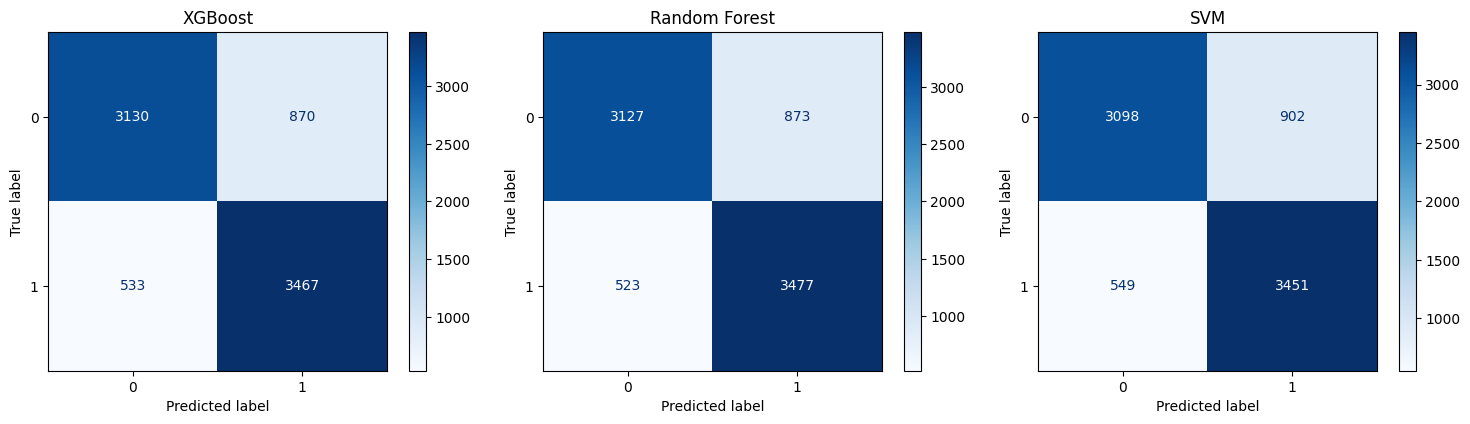

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    "XGBoost": xgb,
    "Random Forest": rf,
    "SVM": svm
}

plt.figure(figsize=(15, 4))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(1, 3, i)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
    plt.title(name)

plt.tight_layout()
plt.show()


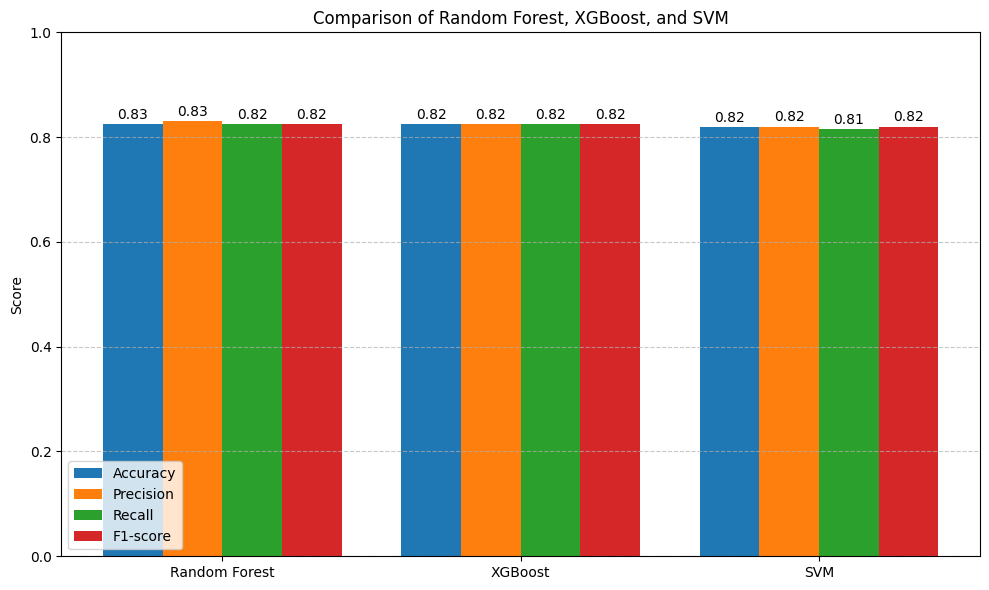

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Metrics for each model
# -------------------------
models = ["Random Forest", "XGBoost", "SVM"]

# Overall Accuracy
accuracy = [0.8255, 0.824625, 0.818625]

# Precision (average of classes 0 & 1)
precision = [(0.86+0.80)/2, (0.85+0.80)/2, (0.85+0.79)/2]

# Recall (average of classes 0 & 1)
recall = [(0.78+0.87)/2, (0.78+0.87)/2, (0.77+0.86)/2]

# F1-score (average of classes 0 & 1)
f1 = [(0.82+0.83)/2, (0.82+0.83)/2, (0.81+0.83)/2]

# -------------------------
# Plotting
# -------------------------
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10,6))
plt.bar(x - width*1.5, accuracy, width, label='Accuracy', color='#1f77b4')
plt.bar(x - width/2, precision, width, label='Precision', color='#ff7f0e')
plt.bar(x + width/2, recall, width, label='Recall', color='#2ca02c')
plt.bar(x + width*1.5, f1, width, label='F1-score', color='#d62728')

plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Comparison of Random Forest, XGBoost, and SVM")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(len(models)):
    plt.text(x[i] - width*1.5, accuracy[i]+0.01, f"{accuracy[i]:.2f}", ha='center')
    plt.text(x[i] - width/2, precision[i]+0.01, f"{precision[i]:.2f}", ha='center')
    plt.text(x[i] + width/2, recall[i]+0.01, f"{recall[i]:.2f}", ha='center')
    plt.text(x[i] + width*1.5, f1[i]+0.01, f"{f1[i]:.2f}", ha='center')

plt.tight_layout()
plt.show()


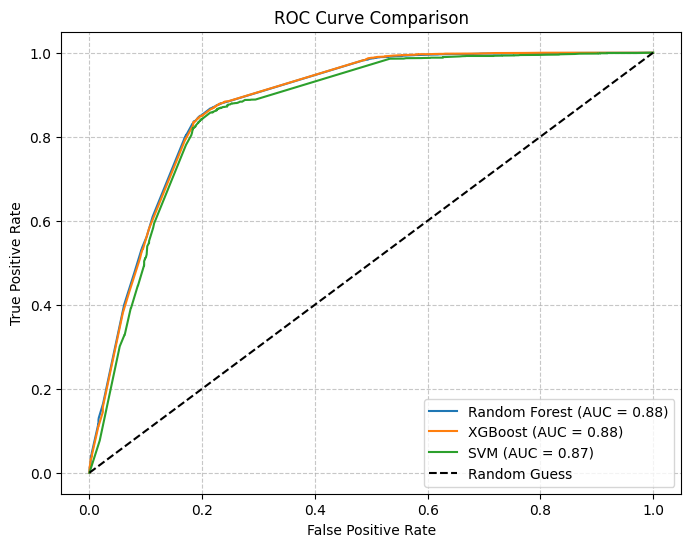

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------
# Get predicted probabilities for class 1
# -------------------------
# Random Forest
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

# XGBoost
y_pred_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# SVM (make sure you trained SVM with probability=True)
y_pred_prob_svm = svm.predict_proba(X_test)[:, 1]

# -------------------------
# Compute ROC curves and AUC
# -------------------------
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# -------------------------
# Plot all ROC curves
# -------------------------
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='#1f77b4', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='#ff7f0e', label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_svm, tpr_svm, color='#2ca02c', label=f'SVM (AUC = {roc_auc_svm:.2f})')

plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import joblib

# Save Random Forest
joblib.dump(rf, "random_forest_model.pkl")

# Save XGBoost
joblib.dump(xgb, "xgboost_model.pkl")

# Save SVM
joblib.dump(svm, "svm_model.pkl")

print("Models saved successfully!")


Models saved successfully!


In [ ]:
urls_to_test = [
    "https://www.google.com",
    "http://bit.ly/2abcdEf",
    "http://phishing-site-example.com/login",
    "https://www.amazon.com",
    "https://login.microsoftonline.com"
]


In [ ]:
import pandas as pd

# Feature names
feature_names = [
    'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth', 'Redirection', 'HTTPS',
    'Shortener', 'Prefix_Suffix', 'Subdomain_Count', 'Digit_Count', 'SpecialChar_Count',
    'Sensitive_Keyword', 'Domain_Age', 'Domain_Extension', 'iFrame', 'MouseOver', 'RightClick',
    'Forwarding', 'Form_Tag', 'Suspicious_JS', 'Trusted_Domain', 'Manual_Shortener',
    'Fake_Secure_Keyword', 'Suspicious_TLD', 'Suspicious_Path'
]

# Extract features
feature_list = [featureExtraction(url) for url in urls_to_test]

# Create DataFrame
df_features = pd.DataFrame(feature_list, columns=feature_names)

# Show all columns
pd.set_option('display.max_columns', None)
print(df_features)


                      Domain  Have_IP  Have_At  URL_Length  URL_Depth  \
0                 google.com        0        0           0          0   
1                     bit.ly        0        0           0          1   
2  phishing-site-example.com        0        0           0          1   
3                 amazon.com        0        0           0          0   
4  login.microsoftonline.com        0        0           0          0   

   Redirection  HTTPS  Shortener  Prefix_Suffix  Subdomain_Count  Digit_Count  \
0            0      1          0              0                1            0   
1            0      0          1              0                1            0   
2            0      0          0              1                1            0   
3            0      1          0              0                1            0   
4            0      1          0              0                2            0   

   SpecialChar_Count  Sensitive_Keyword  Domain_Age  Domain_Extension  iFr

In [ ]:
# Drop 'Domain' for model input
X_test_urls = df_features.drop('Domain', axis=1)

# Models
models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "SVM": svm
}

# Prepare results
results = []

for name, model in models.items():
    probs = model.predict_proba(X_test_urls)[:, 1]  # probability of phishing
    preds = model.predict(X_test_urls)

    for url, pred, prob in zip(urls_to_test, preds, probs):
        label = "Phishing" if pred == 1 else "Legitimate"
        results.append({
            "Model": name,
            "URL": url,
            "Prediction": label,
            "Phishing Probability": round(prob, 2)
        })

# Convert to DataFrame for nice display
df_results = pd.DataFrame(results)
print(df_results)


            Model                                     URL  Prediction  \
0   Random Forest                  https://www.google.com  Legitimate   
1   Random Forest                   http://bit.ly/2abcdEf  Legitimate   
2   Random Forest  http://phishing-site-example.com/login  Legitimate   
3   Random Forest                  https://www.amazon.com  Legitimate   
4   Random Forest       https://login.microsoftonline.com  Legitimate   
5         XGBoost                  https://www.google.com  Legitimate   
6         XGBoost                   http://bit.ly/2abcdEf  Legitimate   
7         XGBoost  http://phishing-site-example.com/login  Legitimate   
8         XGBoost                  https://www.amazon.com  Legitimate   
9         XGBoost       https://login.microsoftonline.com  Legitimate   
10            SVM                  https://www.google.com    Phishing   
11            SVM                   http://bit.ly/2abcdEf  Legitimate   
12            SVM  http://phishing-site-example.com

In [2]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import requests
from urllib.parse import urlparse
import ipaddress, re

# -------------------------
# Page Config
# -------------------------
st.set_page_config(
    page_title="Phishing URL Detection",
    page_icon="🔒",
    layout="centered",
    initial_sidebar_state="collapsed"
)

# -------------------------
# Custom CSS
# -------------------------
st.markdown("""
    <style>
        .stApp { background-color: #0D1B2A; color: #FFFFFF; }
        .stButton>button { background-color: #1B263B; color: #FFFFFF; }
        h1, h2, h3, h4, h5 { color: #E0E1DD; text-align:center; }
    </style>
""", unsafe_allow_html=True)

# -------------------------
# Header
# -------------------------
st.title("🔒 Phishing URL Detection System")
st.markdown("<h3>Project: Phishing URL Detection</h3>", unsafe_allow_html=True)
st.markdown("<h3>University: Ibn Zohr – IT Excellence Center</h3>", unsafe_allow_html=True)
st.markdown("<h3>Master: Data Analytics & AI</h3>", unsafe_allow_html=True)
st.markdown("<h3>Module: Cybersecurity</h3>", unsafe_allow_html=True)

# -------------------------
# Load Models and Thresholds
# -------------------------
rf_model = joblib.load("rf_model.pkl")
xgb_model = joblib.load("xgb_model.pkl")
svc_model = joblib.load("svc_model.pkl")

models = {"Random Forest": rf_model, "XGBoost": xgb_model, "SVC": svc_model}
thresholds = {"Random Forest": 0.4, "XGBoost": 0.4, "SVC": 0.5}

# -------------------------
# Feature Extraction
# -------------------------
feature_columns = [
    'Have_IP','Have_At','URL_Length','URL_Depth','Redirection','HTTPS',
    'Shortener','Prefix_Suffix','Subdomain_Count','Digit_Count','SpecialChar_Count',
    'Sensitive_Keyword','Domain_Age','Domain_Extension','iFrame','MouseOver',
    'RightClick','Forwarding','Form_Tag','Suspicious_JS'
]

def featureExtraction(url):
    features = []
    domain = urlparse(url).netloc.replace("www.", "")
    features.append(domain)

    # Lexical
    try:
        ipaddress.ip_address(domain)
        features.append(1)
    except:
        features.append(0)
    features.append(1 if "@" in url else 0)
    features.append(1 if len(url) >= 54 else 0)
    features.append(len([x for x in urlparse(url).path.split("/") if x]))
    pos = url.rfind("//")
    features.append(1 if pos > 6 else 0)
    features.append(1 if url.startswith("https") else 0)
    features.append(1 if re.search(shortening_services, url) else 0)
    features.append(1 if "-" in domain else 0)
    features.append(len(domain.split("."))-1)
    features.append(sum(c.isdigit() for c in domain))
    features.append(len(re.findall(r"[^a-zA-Z0-9.]", domain)))
    features.append(1 if any(k in url.lower() for k in ["secure","account","update","login","verify","bank","confirm"]) else 0)
    features.append(1 if len(domain)<10 else 0)
    features.append(1 if domain.endswith((".com",".org",".net")) else 0)

    # HTML/JS
    try:
        r = requests.get(url, timeout=3)
        html = r.text
    except:
        html = ""
    features.append(0 if "<iframe" in html else 1)
    features.append(1 if "onmouseover" in html else 0)
    features.append(0 if "event.button" in html else 1)
    features.append(1 if "window.location" in html else 0)
    features.append(1 if "<form" in html else 0)
    features.append(1 if any(f in html for f in ["eval(","escape(","unescape("]) else 0)

    return features

# -------------------------
# URL Input
# -------------------------
url_input = st.text_input("Enter a URL to analyze:")

# -------------------------
# Model Selection
# -------------------------
selected_model_name = st.selectbox("Choose model:", list(models.keys()))
model = models[selected_model_name]
threshold = thresholds[selected_model_name]

# -------------------------
# Prediction
# -------------------------
if st.button("Predict"):
    if not url_input:
        st.warning("Please enter a URL.")
    else:
        domain = urlparse(url_input).netloc.replace("www.","").lower()
        url_lower = url_input.lower()
        tld = "." + domain.split(".")[-1]

        # Apply manual overrides
        override_pred = None
        reasons = []

        if any(td in domain for td in trusted_domains):
            override_pred = "Legitimate"
            reasons.append("Trusted domain")
        if any(s in url_lower for s in shorteners_list):
            override_pred = "Phishing"
            reasons.append("URL shortener detected")
        if any(k in url_lower for k in fake_secure_keywords):
            override_pred = "Phishing"
            reasons.append("Fake 'secure' keywords found")
        if tld in suspicious_tlds:
            override_pred = "Phishing"
            reasons.append("Suspicious TLD")
        if any(p in url_lower for p in suspicious_path_keywords):
            override_pred = "Phishing"
            reasons.append("Suspicious path keywords")
        if "-" in domain:
            reasons.append("Prefix/suffix '-' in domain")
        if sum(c.isdigit() for c in domain) > 3:
            reasons.append("Too many digits in domain")
        if len(domain.split("."))-1 > 3:
            reasons.append("Too many subdomains")

        # Feature extraction
        features = featureExtraction(url_input)

Writing app.py
